This textbook aims to take the aspects of the previous 4 textbooks and apply it more towrads the missing data fitting. The process is going to be done in two parts. The first half is going to be a proof of concept that the general idea still works even if you subtract time series data (i.e. don't feed into it a particular of a set of particular dimentions of data).

The second part is going to be a proof of concept as to the classification capabilities of a feedforwards neural net. I'm going to start simple by associating 3 different types of systems with tags, and training a small neural net to asscoite a tag with a certain tpye of time series data input. Then I'm going to have an automatic pipeline that takes that tag input and sets up the the parameters to be estiamted, generates the type of data associated with that tag, and fits the parameters of that equation. 

If both parts go well, I will create a validation where I randomly generate 1D data from one of the three systems, feed it into the fitted Neural Nets first for classification, then for parameter estimation and comapre. 

If that also succeeds, the next implmentation will be trying the same methodology for AFM data with 3 simple Tip Sample forces and then 3 simple Surface Motion Models. 

In essence then, the first parts are going to be the same as before:
- Define a numerical solver
- Define a neural network initializer
- Generate a random subset of data 
- Set up the neural netowork and loss functions
- Complete the training 

In [1]:
import matplotlib.pyplot as plt

import jax 
import jax.numpy as jnp
import numpy as np
from jax import value_and_grad, jit, random, vmap

import optax
from functools import partial

import tqdm

All the premable code for initialization and numerical solving

In [2]:
def NN_init_params(key, num_neuron_layers):
    params = {}
    params['w'] = []
    params['b'] = []
    for (higher_layer, lower_layer) in zip(num_neuron_layers[1:], num_neuron_layers[:-1]):
        key, subkey = jax.random.split(key)
        params['w'].append(jax.random.normal(subkey, (higher_layer, lower_layer)) / jnp.sqrt(lower_layer))
    for num_neurons in num_neuron_layers[1:]:
        params['b'].append(jnp.zeros(num_neurons))
    return params

def runge_kutta_step_with_params(X, params, t, rhs, dt):
    """
    Single step definition of the 4th order Runge-Kutta method
    X : State vector
    params : Parameter list
    t : Time
    rhs : Function defining right hand side of ODE
    dt: Timestep

    Important item of note, there are a couple conventions with regards to RK solvers
    You can either return the next step (i.e. X + RK_step)
    or you can return the increment (i.e. RK_step)
    This function definition returns the increment
    """

    k1 = rhs(X, t, params)
    k2 = rhs(X + dt/2 * k1, t + dt/2, params)
    k3 = rhs(X + dt/2 * k2, t + dt/2, params)
    k4 = rhs(X + dt * k3, t + dt, params)
    inc = dt/6 * (k1 + 2*k2+ 2*k3 + k4)
    return inc


@partial(jax.jit, static_argnames=['rhs'])
def runge_kutta_solve(X0, rhs, ts, params):
    """
    Loop definition of the 4th order Runge-Kutta method using the single step definition
    X0 : Initial condition vector
    rhs : Function defining right hand side of ODE
    ts : Time vector
    params : Parameter list

    """
    dt=ts[1]-ts[0]

    def loop_body(x,t):
        dx = runge_kutta_step_with_params(x,params,t,rhs,dt)
        x = x + dx
        return x,x
    
    _,Xs=jax.lax.scan(loop_body,X0,ts[:-1])
    return Xs,ts[1:]

# Batch the above function
batched_param_runge_kutta_solve = jax.vmap(runge_kutta_solve, in_axes=[None, None, None, 0], out_axes=0)

batched_runge_kutta_solve = jax.vmap(runge_kutta_solve, in_axes=[0, None, None, None], out_axes=0)



All the premable code for data generation 

In [3]:
def lorenz_rhs(X, t, params):
    """
    Right hand side of the Lorenz system
    X : State vector
    t : Time
    params : Parameter list

    """
    x, y, z = X
    sigma, rho, beta = params
    x_dot = sigma * (y - x)
    y_dot = x*(rho - z) - y
    z_dot = x*y - beta*z
    return jnp.array([x_dot, y_dot, z_dot])

def solve_lorenz(X0, params, t_end, n_steps):
    """
    Solve the Lorenz system using the Runge-Kutta method
    X0 : Initial condition vector
    params : Parameter list (has form [sigma, rho, beta])
    t_end : End time
    n_steps : Number of time steps

    """
    ts = jnp.linspace(0, t_end, n_steps)
    Xs, ts_out = runge_kutta_solve(X0, lorenz_rhs, ts, params)

    return Xs, ts_out

solve_lorenz_batch_params = jax.vmap(solve_lorenz, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_lorenz_batch_X0 = jax.vmap(solve_lorenz, in_axes=(0, None, None, None), out_axes=(0, None))

def random_parameter_vector(key, batchsize, ranges):
    """
    Generate a batch of random parameters of size batchsize 
    within a given range for each parameter.
    key : JAX random key
    batchsize : Number of parameters to generate
    ranges : List of tuples defining (mix, max) for each parameter

    """
    params = []
    subkeys = jax.random.split( key, len(ranges) )
    for subkey, value_range in zip(subkeys, ranges):
        params.append(jax.random.uniform(subkey, [batchsize], minval = value_range[0], maxval = value_range[1]))
    return params

def lorenz_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    sigmas, rhos, betas = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([sigmas, rhos, betas], axis=1)
    Xs, ts = solve_lorenz_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

def NN(x, params):
    """
    Simple feedforwards neural network

    x : Input vector
    params : List of weights and biases

    """
    num_layers = len(params['w'])
    for layer_idx, (w,b) in enumerate(zip(params['w'], params['b'])):
        x = jnp.matmul(w, x) + b
        if layer_idx < num_layers - 1:
           x = jnp.tanh(x)
    return x

NN_batch = jax.vmap(NN, in_axes=(0, None), out_axes=0)
dim_obs_bool = np.array([True, False, False])
keep_idx = tuple(np.nonzero(dim_obs_bool)[0].tolist())

def featurize_batch(Xs, keep_idx=None):
    """
    Normalization and flattening of the input data. Also reduces the dimentionality of the input data
    Xs : Input data of shape (batchsize, n_steps, n_features) to be flattened to (batchsize, n_steps*n_features) (B, T, C) -> (B, T*C)
    dim_obs : Boolen matrix of shape (n_dims, 1) defining which dimentions to keep. 1 = Keep, 0 = Discard

    """
    mean = jnp.mean(Xs, axis=1, keepdims=True)
    std  = jnp.std(Xs,  axis=1, keepdims=True) + 1e-6
    Xn   = (Xs - mean) / std
    if keep_idx is not None:
        Xn = Xn[:, :, keep_idx]                            

    return Xn.reshape(Xn.shape[0], -1)

def mse_loss(nn_params, X_batch, y_target):
    """
    Mean squared error loss function
    x : Input vector
    y_target : Target vector
    params : List of weights and biases

    """
    feats = featurize_batch(X_batch, keep_idx)
    preds = NN_batch(feats, nn_params)
    loss = jnp.sum((preds - y_target)**2 ) 
    return loss

mse_loss_value_and_grad = jax.jit(jax.value_and_grad(mse_loss, argnums = 0))


This marks the training loop and thins associated with the training loop

In [4]:
input_dim = 50
output_dim = 3
losses = []
#These are redefined here because I just wanted to test something above
key = jax.random.key(42)
ranges = [(6.0,12.0), (20.,30.), (0.5,2.5)]  # sigma, rho, beta
X0 = jnp.array([1.,1.,1.])
num_training_batches = 2000
batchsize = 100
tend = 40.0
n_steps = 4000
T = n_steps - 1
D_in = T * int(dim_obs_bool.sum()) 

optimizer = optax.adam(1e-3)

@jax.jit
def train_step(nn_params, opt_state, X_batch, y_target):
    loss, grads = mse_loss_value_and_grad(nn_params, X_batch, y_target)
    updates, opt_state = optimizer.update(grads, opt_state, nn_params)
    nn_params = optax.apply_updates(nn_params, updates)
    return nn_params, opt_state, loss

key = jax.random.key(0)

# Shapes: D_in = (n_steps-1)*3 because your solver returns states at ts[1:]
key, sub = jax.random.split(key)
nn_params = NN_init_params(sub, [D_in, 256, 128, 3])
opt_state = optimizer.init(nn_params)

losses = []

# one batch
key, sub = jax.random.split(key)
Xs, ts, y_target = lorenz_produce_training_batch(sub, batchsize, ranges, tend, n_steps, X0)
feats = featurize_batch(Xs, dim_obs_bool)
preds = NN_batch(feats, nn_params)          # (B,3)
print("preds shape:", preds.shape)          # -> (batchsize, 3)

# one train step
nn_params, opt_state, loss = train_step(nn_params, opt_state, Xs, y_target)
print("loss:", float(loss))

preds shape: (100, 3)
loss: 73122.921875


Just a showcase as to *what* the data I'm passing into the neural net is

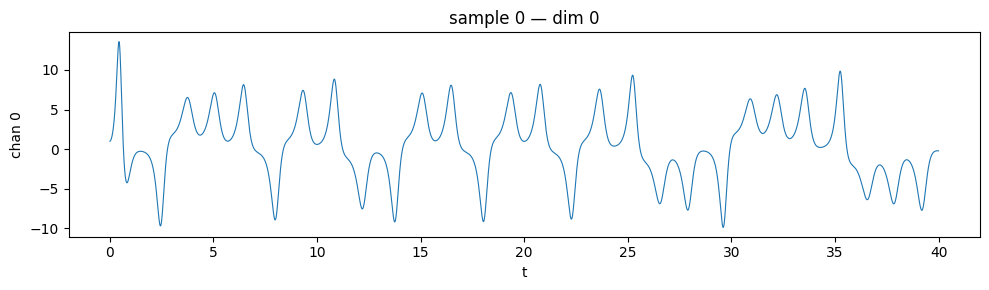

features shape: (1, 3999)


In [5]:
# Pick a random sample from the current batch
key, sk = jax.random.split(key)
i = int(jax.random.randint(sk, (), 0, Xs.shape[0]))

# Turn your boolean mask into integer indices (e.g. [True, True, False] -> (0,1))
obs_idx = tuple(np.nonzero(np.asarray(dim_obs_bool))[0].tolist())  # e.g. (0,1)

# Slice the observed channels from the raw batch (B,T,3) -> (T,C_sel)
t_i   = np.asarray(ts)              # (T,)
X_i   = np.asarray(Xs[i])           # (T,3)
X_obs = X_i[:, obs_idx]             # (T,C_sel)

# 1) Time series for each observed channel
fig, axes = plt.subplots(1, len(obs_idx), figsize=(10, 3), sharex=True)
axes = np.atleast_1d(axes)

for k, ax in enumerate(axes):
    ax.plot(t_i, X_obs[:, k], lw=0.8)
    ax.set_xlabel('t')
    ax.set_ylabel(f'chan {obs_idx[k]}')
    ax.set_title(f'sample {i} — dim {obs_idx[k]}')

plt.tight_layout()
plt.show()

# 2) Optional: phase plot if you kept two channels
if len(obs_idx) == 2:
    plt.figure(figsize=(4,4))
    plt.plot(X_obs[:, 0], X_obs[:, 1], lw=0.8)
    plt.xlabel(f'chan {obs_idx[0]}')
    plt.ylabel(f'chan {obs_idx[1]}')
    plt.title(f'sample {i} — phase plot')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# 3) (Optional) Check feature length matches 2 channels
feats_i = np.asarray(featurize_batch(Xs[i:i+1], dim_obs_bool))  # (1, T*C_sel)
print("features shape:", feats_i.shape)  # expect (1, (n_steps-1) * number_of_kept_channels)

Seperation for the actual training block

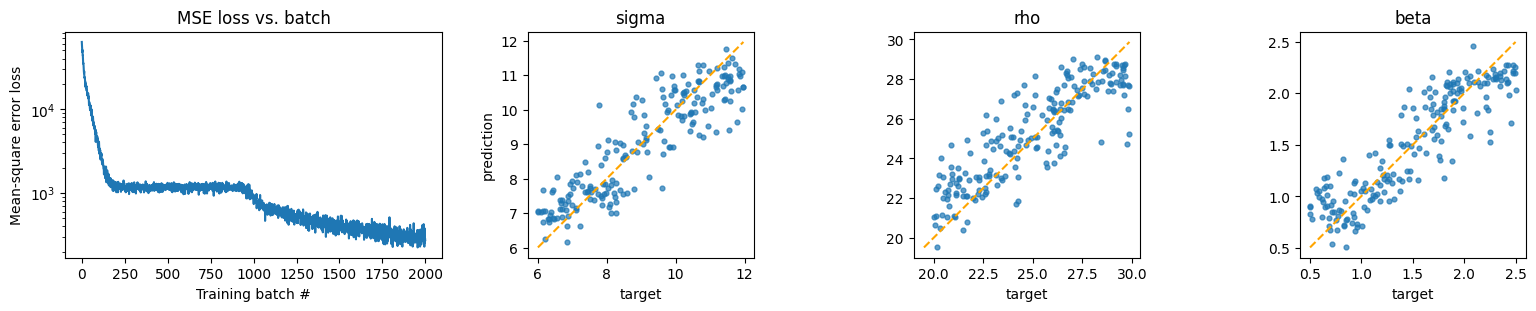

True: [ 6.8624105 21.658443   1.1379092]
NN:   [ 7.3623767 22.134815   1.4169741]


In [6]:
for step in range(num_training_batches):
    key, sub = jax.random.split(key)
    Xs, ts, y_target = lorenz_produce_training_batch(sub, batchsize, ranges, tend, n_steps, X0)  # Xs:(B,T,3)

    nn_params, opt_state, loss = train_step(nn_params, opt_state, Xs, y_target)
    losses.append(loss)

# 1) Build a single row of 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(16, 3), constrained_layout=True)

# --- [0] Loss curve ---
ax[0].plot(np.asarray(losses))
ax[0].set_yscale("log")
ax[0].set_title("MSE loss vs. batch")
ax[0].set_xlabel("Training batch #")
ax[0].set_ylabel("Mean-square error loss")

# 2) Make a fresh validation batch
key, subkey = jax.random.split(key)
Xv, tv, y_target = lorenz_produce_training_batch(
    subkey, 200, ranges, tend, n_steps, X0
)  # Xv: (B,T,3), y_target: (B,3)

# Run the model
feats = featurize_batch(Xv, keep_idx)              # (B, T*3)
y_pred = NN_batch(feats, nn_params)      # (B, 3)

# --- [1..3] Scatter: target vs prediction for each param ---
labels = ["sigma", "rho", "beta"]
for i, label in enumerate(labels, start=1):
    t = np.asarray(y_target[:, i-1]).ravel()   # targets
    p = np.asarray(y_pred[:,  i-1]).ravel()    # predictions

    # Guard against NaN/Inf (shouldn't happen, but keeps plotting robust)
    mask = np.isfinite(t) & np.isfinite(p)
    t, p = t[mask], p[mask]

    ax[i].scatter(t, p, s=12, alpha=0.7)

    # diagonal y=x for reference
    if t.size > 0:
        lo = np.min(np.concatenate([t, p]))
        hi = np.max(np.concatenate([t, p]))
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        ax[i].plot([lo, hi], [lo, hi], "--", color="orange")
        ax[i].set_xlim(lo - pad, hi + pad)
        ax[i].set_ylim(lo - pad, hi + pad)

    ax[i].set_aspect("equal", adjustable="box")
    ax[i].set_title(label)
    ax[i].set_xlabel("target")
    if i == 1:
        ax[i].set_ylabel("prediction")

plt.show()

idx=120 # sample index
print(f"True: {y_target[idx]}")
print(f"NN:   {y_pred[idx]}")

This seems to work rather well even with one dimentional data. Just as a validation for experimental purposes however I generate a random lorenz system from my range, generate one singular system, and solve for it. 

true params  [σ, ρ, β]: [ 8.1546955 24.480598   1.7978237]
predicted     [σ, ρ, β]: [ 7.9828124 24.53779    1.8466983]
percent error              : [2.1077807  0.23362112 2.7185435 ]


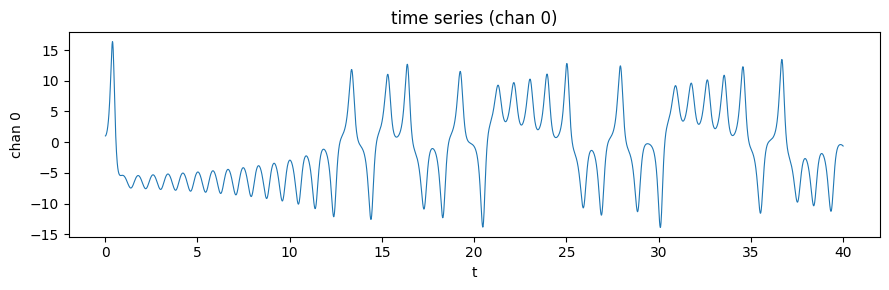

In [7]:
# --- helper: draw one random parameter triple in your ranges ---
def draw_lorenz_params(key, ranges):
    # ranges = [(σmin,σmax), (ρmin,ρmax), (βmin,βmax)]
    k1,k2,k3 = jax.random.split(key, 3)
    σ = jax.random.uniform(k1, (), minval=ranges[0][0], maxval=ranges[0][1])
    ρ = jax.random.uniform(k2, (), minval=ranges[1][0], maxval=ranges[1][1])
    β = jax.random.uniform(k3, (), minval=ranges[2][0], maxval=ranges[2][1])
    return jnp.array([σ, ρ, β])

# --- inference on one fresh system ---
key, sub = jax.random.split(key)
params_true = draw_lorenz_params(sub, ranges)           # (3,)
Xs, ts = solve_lorenz(X0, params_true, tend, n_steps)   # Xs: (T,3) with T = n_steps-1

# batchify to shape (B,T,3) and featurize exactly as in training (same dim_obs!)
X_batch = Xs[None, :, :]                                # (1,T,3)
feats   = featurize_batch(X_batch, dim_obs_bool)             # (1, D_in)

# predict
y_pred = NN_batch(feats, nn_params)[0]                  # (3,)
print("true params  [σ, ρ, β]:", np.asarray(params_true))
print("predicted     [σ, ρ, β]:", np.asarray(y_pred))
print("percent error              :", np.abs(np.asarray((y_pred - params_true)/params_true))*100)

# --- quick plots to eyeball the input you actually fed (observed channels only) ---
obs_idx = tuple(np.nonzero(np.asarray(dim_obs_bool))[0].tolist())  # e.g. (0,1) for x,y
X_obs   = np.asarray(Xs[:, obs_idx])                          # (T, C_sel)

fig, axes = plt.subplots(1, len(obs_idx), figsize=(9,3), sharex=True)
axes = np.atleast_1d(axes)
for k, ax in enumerate(axes):
    ax.plot(np.asarray(ts), X_obs[:, k], lw=0.8)
    ax.set_xlabel('t'); ax.set_ylabel(f'chan {obs_idx[k]}')
    ax.set_title(f'time series (chan {obs_idx[k]})')
plt.tight_layout(); plt.show()

# Optional: phase plot if 2 channels were used
if len(obs_idx) == 2:
    plt.figure(figsize=(4,4))
    plt.plot(X_obs[:,0], X_obs[:,1], lw=0.8)
    plt.xlabel(f'chan {obs_idx[0]}'); plt.ylabel(f'chan {obs_idx[1]}')
    plt.title('phase plot (observed channels)')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

Now that that proof of concept is shown to be working, I'm moving onto the second part of the project which is going to do with the classification of the systems. Now I need to first, generate data from a total of three seperate systems and then I need to be able to make a neural net (or a variety of neural nets) that take in as an input a dimentional chanel of time series data which firstly gets classifed onto the system and then parameter fitted. While I think that multiple networks might be the easier way to go I am led to believe that its more generalizable and more common practice to do this type of analysis in one go as opposed to multiple.

I asked Can, and what he said was to try to employ a Mixture of Experts (MoE) map. How a MoE map works is its a twofold process. There exist "routers" or "gaters" and "experts". The experts are the aspect of the network that do the fitting process. The loss is defined as the loss over the whole set of possible systems. If you were to imagine that we have 3 dynamic systems, we are going to have 3 losses associated with those systems. The point of the router is to be the process that engages or disengages the specific losses that are associated with the system. So while you have:
\begin{equation} 
loss_t = loss_{sys1} + loss_{sys2} + loss_{sys3}
\tag{1}
\end{equation}

The router's job is to recognize which model the dataset belongs to and engage the particular loss associated with that system.

The first step then is going to be defining and being able to numerically solve and batch for the other systems. I've arbitrarily chosen the Chen (Multiscroll) and Rössler Attractors. 

The equational forms for both are defined below:

\begin{equation}
\begin{aligned}
\dot{x} &= \alpha (y-x) \\
\dot{y} &= (\gamma - \alpha)x - xz + \gamma y \\
\dot{z} &= xy - \epsilon z
\tag{Chen}
\end{aligned}
\end{equation}
And for the other system
\begin{equation}
\begin{aligned}
\dot{x} &= -y-z \\
\dot{y} &= x + \phi y \\
\dot{z} &= \theta + z(x-\xi)
\tag{Rössler}
\end{aligned}
\end{equation}

In [8]:
def chen_rhs(X, t, params):
    """
    Right hand side of the Chen system
    X : State vector
    t : Time
    params : Parameter list
    """
    x, y, z = X
    alpha, gamma, epsilon = params
    x_dot = alpha * (y - x)
    y_dot = (gamma - alpha) * x - x*z + gamma * y
    z_dot = x*y - epsilon * z
    return jnp.array([x_dot, y_dot, z_dot])

def rossler_rhs(X, t, params):
    """
    Right hand side of the Rossler system
    X : State vector
    t : Time
    params : Parameter List
    """
    x, y, z = X
    phi, theta, xi = params
    x_dot = -y - z
    y_dot = x + phi * y
    z_dot = theta + z * (x - xi)
    return jnp.array([x_dot, y_dot, z_dot])

def solve_chen(X0, params, tend, nsteps):
    """
    Solve the Chen system using the Runge-Kutta method
    X0 : Initial state vector
    params : Parameter list
    tend : End time
    nsteps : Number of time steps 
    """
    ts = jnp.linspace(0, tend, nsteps)
    Xs, ts_out = runge_kutta_solve(X0, chen_rhs, ts, params)
    return Xs, ts_out

def solve_rossler(X0, params, tend, nsteps):
    """
    Solve the Rossler system using the Runge-Kutta method
    X0 : Initial state vector
    params : Parameter list
    tend : End time
    nsteps : Number of time steps 
    """
    ts = jnp.linspace(0, tend, nsteps)
    Xs, ts_out = runge_kutta_solve(X0, rossler_rhs, ts, params)
    return Xs, ts_out

solve_chen_batch_params = jax.vmap(solve_chen, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_chen_batch_X0 = jax.vmap(solve_chen, in_axes=(0, None, None, None), out_axes=(0, None))
solve_rossler_batch_params = jax.vmap(solve_rossler, in_axes=(None, 0, None, None), out_axes=(0,None))
solve_rossler_batch_X0 = jax.vmap(solve_rossler, in_axes=(0, None, None, None), out_axes=(0, None))

def chen_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    alphas, gammas, epsilons = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([alphas, gammas, epsilons], axis=1)
    Xs, ts = solve_chen_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

def rossler_produce_training_batch(key, batchsize, ranges, t_end, n_steps, X0):
    """
    Produce a batch of training data with random parameters
    key : Random Jax key
    batchsize : Number of training examples to produce
    ranges : List of tuples defining (min, max) for each parameter
    t_end : End time for simulation
    n_steps : Number of time steps for simulation

    """
    phis, thetas, xis = random_parameter_vector(key, batchsize, ranges)
    params = jnp.stack([phis, thetas, xis], axis=1)
    Xs, ts = solve_rossler_batch_params(X0, params, t_end, n_steps)
    return Xs, ts, params

To quickly test if the chen and rössler system definitions work, plot some outcomes below:

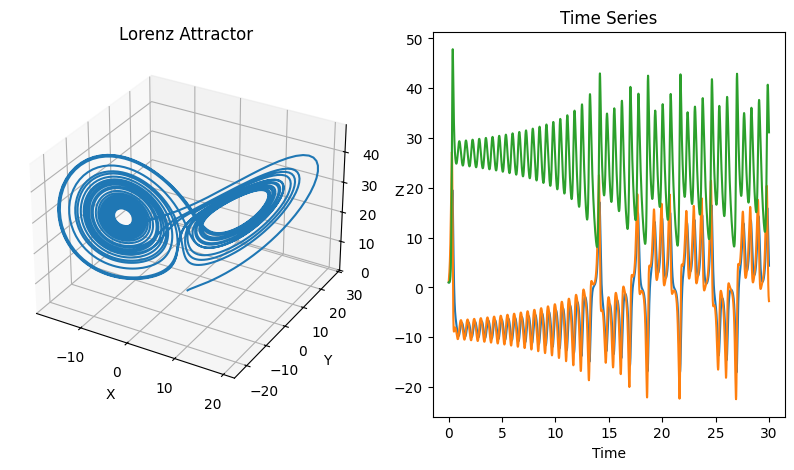

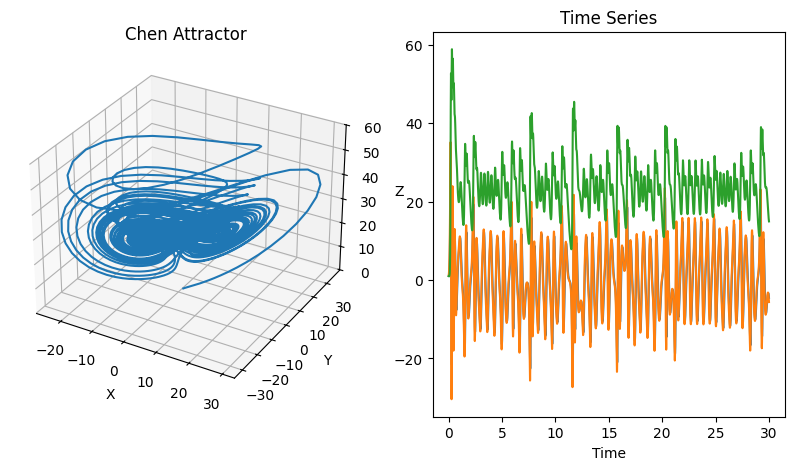

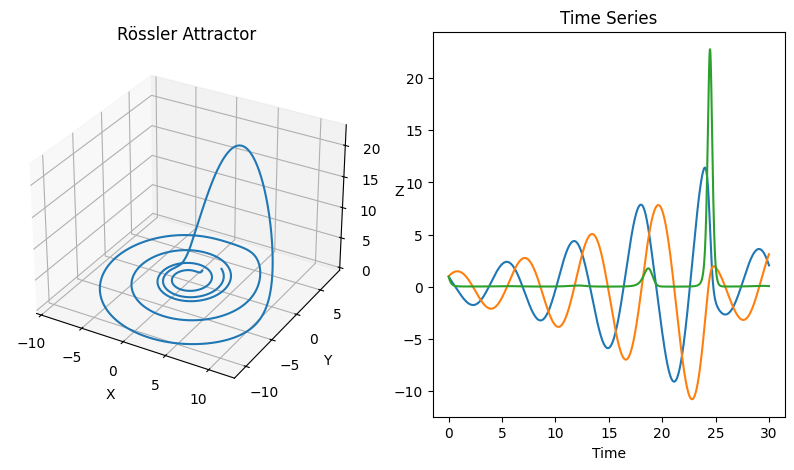

In [9]:
X0 = jnp.array([1.0, 1.0, 1.0])
X0_chen = jnp.array([0.1, 0.3, -0.6])
lorenz_params  = jnp.array([10.0, 28.0, 8/3])      # [sigma, rho, beta]
rossler_params = jnp.array([0.2, 0.2, 5.7])        # [phi, theta, xi]
chen_params    = jnp.array([35.0, 28.0, 3.0])      # [alpha, gamma, epsilon]

t_end = 30.0
n_steps = 4000
Xs, ts = solve_lorenz(X0, lorenz_params, t_end, n_steps)
Xs_chen, ts_chen = solve_chen(X0, chen_params, t_end, n_steps)
Xs_rossler, ts_rossler = solve_rossler(X0, rossler_params, t_end, n_steps)

# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2])
ax.set_title('Lorenz Attractor')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax2 = fig.add_subplot(122)
ax2.plot(ts, Xs)
ax2.set_title('Time Series')
ax2.set_xlabel('Time')
plt.show()

# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot(Xs_chen[:,0], Xs_chen[:,1], Xs_chen[:,2])
ax.set_title('Chen Attractor')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax2 = fig.add_subplot(122)
ax2.plot(ts, Xs_chen)
ax2.set_title('Time Series')
ax2.set_xlabel('Time')
plt.show()

# Plotting
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot(Xs_rossler[:,0], Xs_rossler[:,1], Xs_rossler[:,2])
ax.set_title('Rössler Attractor')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax2 = fig.add_subplot(122)
ax2.plot(ts, Xs_rossler)
ax2.set_title('Time Series')
ax2.set_xlabel('Time')
plt.show()

Now it begins. We already have the core of what we want to achieve set up. We need to go through some preamble to make sure that things is consistent/ generalizable. The ranges dictionary tracks for each system the ranges in one parameter as opposed to have multile lists. It also (implicitly) maps every system to a particular number; Lorenz to 0, Chen to 1, and Rössler to 2. The reg_dims dictionary tells us for each system what the number of optimizable parameters are supposed to be. S gives us the total number of systems and Pmax tells us the largest parameter list (i.e. which system has the most constants to be fitted). For this implementation it doesn't matter but if in the future one equation has greater or fewer parameters than the others, it will create issues in jax.jit given that different systems will have different sized parameter arrays. This is just for future proofing purposes at this point. 

We still need to explicity map which rhs equational form corresponds to which number to which is what sys_fun accomplishes. Then we need to define some functions to make sure that we can generate an equal amount of random data from each different system state. 

In [10]:
ranges = {
    0 : [(6.0, 12.0), (20.,30.), (0.5,2.5)],  # Lorenz: sigma, rho, beta
    1 : [(30.0, 40.0), (20.0, 30.0), (1.0, 5.0)], #Chen: alpha, gamma, epsilon
    2 : [(0.1, 0.3), (0.1, 0.3), (5.2, 6.2) ] #Rössler: phi, theta, xi
}

reg_dims = {0:3, 1:3, 2:3}
S  = 3
Pmax = max(reg_dims.values())

sys_fun = {0: lorenz_rhs, 1: chen_rhs, 2: rossler_rhs}

def draw_params_for_system(key, sys_id, ranges):
    """"
    Draw a random parameter vector for a given system id
    key : Random Jax key
    sys_id : System ID (0 = Lorenz, 1 = Chen, 2 = Rössler)
    ranges : Dictionary of parameter ranges for each system"""
    ks = jax.random.split(key, len(ranges[sys_id]))
    vals = [jax.random.uniform(k, (), minval=lo, maxval=hi)
            for k, (lo,hi) in zip(ks, ranges[sys_id])]
    return jnp.stack(vals)  # (P_s,)

def simulate_one(key, sys_id, X0, t_end, n_steps, ranges):
    """
    Simulate one trajectory for a given system ID
    key : Random Jax key
    sys_id : System ID (0 = Lorenz, 1 = Chen, 2 = Rössler)
    X0 : Initial state vector
    t_end : End time
    n_steps : Number of time steps
    ranges : Dictionary of parameter ranges for each system
    """
    ts = jnp.linspace(0., t_end, n_steps)
    params = draw_params_for_system(key, sys_id, ranges)
    Xs, _  = runge_kutta_solve(X0, sys_fun[sys_id], ts, params)  # (T,3) with T=n_steps-1
    return Xs, ts[1:], params


Effectivley what I achieve with the above two functions is the same as when I defined the random_parameter_vector and solve_sys functions. The main difference is now it generates the time series output for any given one of the three systems associated with a sys_id. Similarly now I need to proceed as I did before and featureize the batches. Previously I avoided the issue with potential mismatch associated with dimention channels by slicing the the time series input and the first dimention of the neural net. From what I gather another way to do this is to pad the channels such that the input is always 3 channel but only the wanted channels are filled with the actual time series data whereas the other channels are zeroed out. This helps Jax with the jitting process. Then I featurize as before to make sure where I take the overall input from size (batchsize, n_steps-1, channels) -> (batchsize, channels * (n_steps -1)). 

Afterwords, we want to take the two functions defined below and combine them to generate everything we want for our loss in one go. Effectivley each data input into the neural net has to have 3 aspects:
- time series data with the wanted dimentionality
- the true parameters that were used to generate that time series data
- the system tag that defines what system that data is associated with

In [11]:
def pad_channels(Xs_raw, keep_idx, C_max=3):
    """
    Xs_raw : Measurement data in the form (batchsize, timesteps-1, channels) where channels can be 1,2 or 3
    keep_idx : Tuple of positions inditcating with channels are present (e.g., (0,) for x; (0,2) for x,z; (0,1,2) for x,y,z)
    C_max : Maximum number of channels (i.e. max dimentionality of the data)

    returns (B,T,C_max) with zeros in missing channels.
    """
    B,T,C_in = Xs_raw.shape 
    Xpad = jnp.zeros((B,T,C_max), dtype=Xs_raw.dtype)
    for src, dst in enumerate(keep_idx):
        Xpad = Xpad.at[:, :, dst].set(Xs_raw[:, :, src])
    return Xpad

def featurize_padded(Xs_pad):
    # per-sample, per-channel z-score over time, then flatten
    mean = jnp.mean(Xs_pad, axis=1, keepdims=True)
    std  = jnp.std(Xs_pad,  axis=1, keepdims=True) + 1e-6
    Xn   = (Xs_pad - mean) / std
    return Xn.reshape(Xn.shape[0], -1)  # (B, T*C_max)

The point of the to_padded_params function is to make things jit friendly. the variable length parameter vectors need to be turned into 

In [12]:
def to_padded_params(params_vec, reg_dim, Pmax):
    """
    """
    pad = Pmax - reg_dim
    y   = jnp.pad(params_vec, (0, pad))
    m   = jnp.concatenate([jnp.ones((reg_dim,)), jnp.zeros((pad,))])
    return y, m

def produce_system_batch(key, B_batch, keep_idx, X0, t_end, n_steps, ranges):
    """
    key : Random Jax key
    B_batch : Batchsize 
    keep_idx : Tuple of positions inditcating with channels are present (e.g., (0,) for x; (0,2) for x,z; (0,1,2) for x,y,z)
    X0 : Initial state vector 
    t_end : Time for simulation
    n_steps : Number of time steps of simulation
    ranges : Dictionary containing the ranges for each system

    Returns:
      feats: (batchsize, input dimention),  sys_ids: (batchsize,)
      y_params_padded: (batchsize, max parameter amount),
      y_mask: (batchsize, max parameter amount)
    """
    T = n_steps - 1
    keys = jax.random.split(key, B_batch + 1)
    key_sys, keys_draw = keys[0], keys[1:]

    # sample system ids uniformly
    sys_ids = jax.random.randint(key_sys, (B_batch,), 0, S)

    X_list, y_list, m_list = [], [], []
    for i in range(B_batch):
        k1, k2 = jax.random.split(keys_draw[i])
        sid = int(sys_ids[i])
        Xs, ts, p = simulate_one(k1, sid, X0, t_end, n_steps, ranges)   # (T,3), (T,)
        # keep the observed channels (here we pretend your measurement already matches keep_idx)
        Xs_raw = Xs[None, :, :]                         # (1,T,3) -> you can slice to 1/2 ch if you like
        # If your raw data only has some channels, pass that as Xs_raw and set keep_idx accordingly.
        Xs_pad = pad_channels(Xs_raw, keep_idx, C_max=3)# (1,T,3)
        feats   = featurize_padded(Xs_pad)              # (1, T*3)
        y_pad, m = to_padded_params(p, reg_dims[sid], Pmax)
        X_list.append(feats[0]); y_list.append(y_pad); m_list.append(m)

    feats = jnp.stack(X_list, axis=0)                   # (B, D_in)
    y_params_padded = jnp.stack(y_list, axis=0)         # (B, Pmax)
    y_mask = jnp.stack(m_list, axis=0)                  # (B, Pmax)
    return feats, sys_ids, y_params_padded, y_mask

Now I define different parts of the Neural Net. For the sake of simplicity I've seperated the different parts into function to be called. However the skeleton of what we want to do remains the same for quite of lot of the functions. The only difference is the MoE aspect. In essence the MoE is performed in two steps. You have an encoder (made of MLPs) that extracts the common features of all types of inputs. You have a router that whose job it is to classify which system generated the time series in question, and you have a series of experts (also MLPs in this case) who map different parameters of the different systems onto the true parameters. 

In [13]:
def init_linear(key, din, dout):
    """
    key : Random Jax key
    din : Input dimention
    dout : Output dimention

    Returns : Dictionaries of 'W' (weights) and 'B' (baises)
    """
    W = jax.random.normal(key, (din, dout)) / jnp.sqrt(din)
    b = jnp.zeros((dout,))
    return {'W': W, 'b': b}

def apply_linear(params, x):  # x: (B,din)
    """
    params : Parameter list
    x : Input state
    
    Returns : The (wx+b) layer of the neural net
    """
    return x @ params['W'] + params['b']

def init_mlp(key, sizes):
    """
    key : Random Jax key
    sizes : Number of layers
    
    Return : Construct the initial weights and baises of the neural net 
            using the init_layer function
    """
    params = []
    ks = jax.random.split(key, len(sizes)-1)
    for (din, dout), k in zip(zip(sizes[:-1], sizes[1:]), ks):
        params.append(init_linear(k, din, dout))
    return params

def apply_mlp(params, x):
    """
    params : Parameter list
    x : State vector
    
    Returns : The full output of a single neural net pass, from the matmul to the 
            activation function
    """
    for i, lyr in enumerate(params):
        x = apply_linear(lyr, x)
        if i < len(params)-1:
            x = jnp.tanh(x)
    return x

def init_moe(key, D_in, enc_sizes, reg_dims, n_systems=S):
    """
    key: Random Jax key
    D_in : Input dimention
    enc_sizes : List of encoder sizes (except for the input dimetion)
    reg_dims : Dictionaory of number of parameters of different systems
    n_systems : Number of system
    
    Returns : A dictionary of enc: parameters of the encoded MLP, gate: linear head for the router logistics,
        experts: MLPs (or linear layers) that do the parameter estimation
    """
    k_enc, k_gate, *k_exps = jax.random.split(key, 2 + n_systems)
    enc = init_mlp(k_enc, [D_in, *enc_sizes])             # encoder -> H
    H   = enc_sizes[-1]
    gate = init_linear(k_gate, H, n_systems)              # router head
    experts = {s: init_linear(k_exps[s], H, reg_dims[s]) for s in range(n_systems)}
    return {'enc': enc, 'gate': gate, 'experts': experts}

def forward_moe(params, feats):
    """
    params : Parameter list
    feats : Time series data 
    reg_dims : Dictionaory of number of parameters of different systems
    Pmax : Max number of parameters in reg_dims

    Returns : Forwards pass of one MoE layer in logits: router scores (i.e. probabilites associated with each system),
        and preds: per system parameter predictions
    """

    h      = apply_mlp(params['enc'], feats)   # (B,H)
    logits = apply_linear(params['gate'], h)   # (B,S)

    # Compute Pmax from static shapes of expert heads (no runtime args)
    S = len(params['experts'])
    Pmax = max(params['experts'][s]['b'].shape[0] for s in range(S))  # Python int

    preds = []
    for s in range(S):
        head = params['experts'][s]
        p    = apply_linear(head, h)                       # (B, P_s)
        Ps   = head['b'].shape[0]                          # Python int (static)
        pad  = jnp.zeros((p.shape[0], Pmax - Ps), dtype=p.dtype)  # (B, Pmax-Ps)
        p_pad = jnp.concatenate([p, pad], axis=1)          # (B, Pmax) (works even if Pmax-Ps == 0)
        preds.append(p_pad)

    preds = jnp.stack(preds, axis=1)                       # (B,S,Pmax)
    return logits, preds

def moe_loss(params, feats, sys_ids, y_params_padded, y_mask, lam_reg=0.5):
    """
    params : Parameter list
    feats : Time series data
    sys_ids : Numerical identifier of system
    y_params_padded : True parameter vectors extended to Pmax
    y_mask : Mask that only retains wanted dimentions
    reg_dims : Dimtionary of number of parameters of different systems
    Pmax : Max number of parameters in reg_dims
    lam_reg : Weight balancing classification and regression
    
    Returns : The full calculated loss of the function
    """
    logits, preds = forward_moe(params, feats)
    ce = optax.softmax_cross_entropy_with_integer_labels(logits, sys_ids).mean()

    onehot = jax.nn.one_hot(sys_ids, logits.shape[-1])[:, :, None]  # (B,S,1)
    pred_true = jnp.sum(preds * onehot, axis=1)                     # (B,Pmax)

    num = jnp.sum(((pred_true - y_params_padded)**2) * y_mask)
    den = jnp.sum(y_mask) + 1e-8
    mse = num / den
    return ce + lam_reg * mse

moe_valgrad = jax.jit(jax.value_and_grad(moe_loss, argnums=0))

@jax.jit
def train_step(params, opt_state, feats, sys_ids, y_params_padded, y_mask):
    loss, grads = moe_valgrad(params, feats, sys_ids, y_params_padded, y_mask)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [16]:
# Config
X0 = jnp.array([1.,1.,1.])
t_end, n_steps = 40.0, 4000
T = n_steps - 1
D_in = T * 3                     # padded to 3
enc_sizes = [256, 128]           # encoder widths
optimizer = optax.adam(1e-3)
num_steps = 25000

# Init
key = jax.random.key(0)
key, kinit = jax.random.split(key)
moe_params = init_moe(kinit, D_in, enc_sizes, reg_dims, n_systems=S)
opt_state  = optimizer.init(moe_params)
B_train = 128
B_val = 400

losses = []


In [17]:
#Training Loop
for step in range(num_steps):
    key, kb = jax.random.split(key)
    feats, sys_ids, y_pad, y_mask = produce_system_batch(
        kb, B_batch=B_train, keep_idx=keep_idx, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges
    )
    moe_params, opt_state, loss = train_step(moe_params, opt_state, feats, sys_ids, y_pad, y_mask)
    losses.append(float(loss))   # store as Python float

# ---- Validation batch
key, kb = jax.random.split(key)
feats, sys_ids, y_pad, y_mask = produce_system_batch(
    kb, B_batch=B_val, keep_idx=keep_idx, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges
)



TypeError: 'int' object is not iterable

In [ ]:
# After: feats, sys_ids, y_pad, y_mask = produce_system_batch(...)
counts = np.bincount(np.asarray(sys_ids), minlength=S)
print("val sys_id counts:", {i:int(c) for i,c in enumerate(counts)})

# ---- Forward pass (validation)
logits, preds = forward_moe(moe_params, feats)          # logits:(?,S), preds:(?,S,Pmax)

# To NumPy + shapes
preds_np  = np.asarray(preds)                             # (Bp,S,Pmax)
sys_np    = np.asarray(sys_ids, dtype=np.int32).reshape(-1)  # (Bi,)
y_pad_np  = np.asarray(y_pad)                            # (By,Pmax)
y_mask_np = np.asarray(y_mask)                           # (Bm,Pmax)

Bp, S, Pmax = preds_np.shape
Bi, By, Bm  = sys_np.shape[0], y_pad_np.shape[0], y_mask_np.shape[0]

# Align leading dims if they differ (e.g., train B=128 vs. val B=400)
if len({Bp, Bi, By, Bm}) != 1:
    minB = min(Bp, Bi, By, Bm)
    print(f"[plot] Mismatched batch sizes (preds={Bp}, sys={Bi}, y={By}, mask={Bm}); truncating to {minB}.")
    preds_np  = preds_np[:minB]
    sys_np    = sys_np[:minB]
    y_pad_np  = y_pad_np[:minB]
    y_mask_np = y_mask_np[:minB]
else:
    minB = Bp

B = minB  # use this B from here on

# Pick the *true-system* expert output (same as before)
pred_np = np.take_along_axis(preds_np, sys_np[:, None, None], axis=1)[:, 0, :]   # (B,Pmax)

# ---- Names (only change!)
SYSTEM_NAMES = {
    0: "Lorenz",
    1: "Chen",
    2: "Rössler",
}

PARAM_NAMES = {
    0: ["sigma", "rho", "beta"],     # Lorenz
    1: ["alpha", "gamma", "epsilon"], # Chen
    2: ["phi", "theta", "xi"],       # Rössler 

}

# ---- Figure 0: loss curve (unchanged)
fig0, ax0 = plt.subplots(ncols=1, figsize=(5, 3), constrained_layout=True)
ax0.plot(np.asarray(losses))
ax0.set_yscale("log")
ax0.set_title("Total loss vs. step")
ax0.set_xlabel("Training step"); ax0.set_ylabel("Loss")
plt.show()

# ---- Figure 1: grid of scatters (rows=Pmax, cols=S)  <-- back to your original layout
fig, ax = plt.subplots(nrows=Pmax, ncols=S, figsize=(4*S, 3*Pmax),
                       constrained_layout=True, squeeze=False)

for s in range(S):
    sel = (sys_np == s)
    if not np.any(sel):
        for r in range(Pmax):
            ax[r, s].axis('off')
        ax[0, s].set_title(f"{SYSTEM_NAMES.get(s, f'System {s}')} (no samples)")
        continue

    # Same assumption as before: first sample of this system defines valid columns
    cols = np.where(y_mask_np[sel][0] == 1)[0]
    names = PARAM_NAMES.get(s, [f"p{j}" for j in range(len(cols))])

    for j, c in enumerate(cols):
        a = ax[j, s]
        t = y_pad_np[sel, c]
        p = pred_np[sel, c]
        m = np.isfinite(t) & np.isfinite(p)
        t, p = t[m], p[m]
        if t.size == 0:
            a.axis('off'); continue

        a.scatter(t, p, s=12, alpha=0.7)
        lo = np.min(np.concatenate([t, p])); hi = np.max(np.concatenate([t, p]))
        pad = 0.05 * (hi - lo) if hi > lo else 1.0
        a.plot([lo, hi], [lo, hi], "--", color="orange")
        a.set_xlim(lo - pad, hi + pad); a.set_ylim(lo - pad, hi + pad)
        a.set_aspect("equal", adjustable="box")

        pname = names[j] if j < len(names) else f"p{j}"
        a.set_xlabel(f"true {pname}")
        if s == 0:
            a.set_ylabel(f"pred {pname}")

    # turn off unused rows
    for r in range(len(cols), Pmax):
        ax[r, s].axis('off')

    # Title uses system display name + parameter names
    ax[0, s].set_title(f"{SYSTEM_NAMES.get(s, f'System {s}')} — {', '.join(names)}")

plt.show()

In [ ]:
# Simulate one example (say Lü)
key, kx = jax.random.split(key)
Xs, ts, params_true = simulate_one(kx, sys_id=2, X0=X0, t_end=t_end, n_steps=n_steps, ranges=ranges)
# Suppose your measurement only sees x,z: build raw (T,2) and place it into (0,2)
X_raw = jnp.stack([Xs[:,0], Xs[:,2]], axis=-1)[None, :, :]   # (1,T,2)
X_pad = pad_channels(X_raw, keep_idx=(0,2), C_max=3)         # (1,T,3)
feats = featurize_padded(X_pad)                              # (1,D_in)

logits, preds = forward_moe(moe_params, feats)
p = jax.nn.softmax(logits, axis=-1)[0]
s_hat = int(jnp.argmax(p))                                   # predicted system
pred_padded = preds[0, s_hat]                                # (Pmax,)
pred_params = pred_padded[:reg_dims[s_hat]]
print("router probs:", np.asarray(p))
print("system id (0=Lorenz,1=Rössler,2=Lü):", s_hat)
print("true params:", np.asarray(params_true))
print("pred params:", np.asarray(pred_params))
per_err = 100.0 * np.abs((np.asarray(pred_params) - np.asarray(params_true)) / np.asarray(params_true))
print("percent error:", per_err)